<a href="https://colab.research.google.com/github/duraichellam001-tech/ev-range-model/blob/main/notebooks/05_lstm_energy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')

# ---------- 1️⃣ Load all datasets ----------
df_udds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ev-range-model/data/UDDS.csv")
df_udds.columns = ["time","speed"]

df_hwy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ev-range-model/data/EPA_HWY.csv")
df_hwy.columns = ["time","speed"]

df_us06 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ev-range-model/data/EPA_US06.csv")
df_us06.columns = ["time","speed"]

df = [df_udds,df_hwy,df_us06]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
mass = 1600      # kg
Cd = 0.28
A  = 2.2         # m²
rho = 1.225      # air density (kg/m³)
Crr = 0.012
eta = 0.9
dt = 1.0         # assuming 1-second timestep

# -------------------------------------------------
# 2️⃣ Function to compute derived physics quantities
# -------------------------------------------------
def process_cycle(df):
    seq_df = df.copy()
    seq_df['v'] = seq_df['speed'] * (1000/3600) * 1.6      # convert km/h → m/s
    seq_df['a'] = seq_df['v'].diff().fillna(0) / dt  # m/s²
    seq_df['F_rr'] = mass * 9.81 * Crr
    seq_df['F_aero'] = 0.5 * rho * A * Cd * (seq_df['v']**2)
    seq_df['F_acc'] = mass * seq_df['a']
    seq_df['F_total'] = seq_df['F_rr'] + seq_df['F_aero'] + seq_df['F_acc']
    seq_df['P_wheel'] = seq_df['F_total'] * seq_df['v']
    seq_df['P_batt'] = (seq_df['P_wheel'] / eta).clip(lower=0)
    return seq_df

# -------------------------------------------------
# 3️⃣ Apply to all drive cycles
# -------------------------------------------------
df_udds = process_cycle(df_udds)
df_hwy  = process_cycle(df_hwy)
df_us06 = process_cycle(df_us06)

In [90]:
df_udds_aug = process_cycle(df_udds.copy())
df_udds_aug['speed'] *= 1.2  # create “faster UDDS”
df_udds_aug = process_cycle(df_udds_aug)

train_dfs = [df_hwy, df_us06, df_udds_aug]
test_df   = df_udds

In [91]:
from sklearn.preprocessing import StandardScaler

scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

train_concat = pd.concat(train_dfs, ignore_index=True)
X_train_raw = train_concat[['v','a']].values
y_train_raw = train_concat[['P_batt']].values

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

In [92]:
def create_sequences(X, y, window=10):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

window = 10
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, window)

In [93]:
model = Sequential([
    LSTM(64, input_shape=(window, 2)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(1e-4), loss='mse')
model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1, shuffle=False)

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.8477
Epoch 2/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8414
Epoch 3/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8383
Epoch 4/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8335
Epoch 5/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8339
Epoch 6/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8290
Epoch 7/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8255
Epoch 8/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8224
Epoch 9/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8194
Epoch 10/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8163
Epoch 11/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8132
Epoch 12/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8101
Epoch 13/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8068
Epoch 14/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8036
Epoch 15/60
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8002
Epoch 16/60
86/86 ━━━━━━━━━━━

In [96]:
# scale UDDS data
X_test_scaled = scaler_X.transform(test_df[['v','a']])
y_test_scaled = scaler_y.transform(test_df[['P_batt']])

# create sequences for prediction
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window)
pred_scaled = model.predict(X_test_seq)
#pred_scaled = np.clip(pred_scaled, 0, 1)
pred_watt = scaler_y.inverse_transform(pred_scaled).flatten()

# align predictions to time
pred_full = np.full(len(test_df), np.nan)
pred_full[window:] = pred_watt

 1/43 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


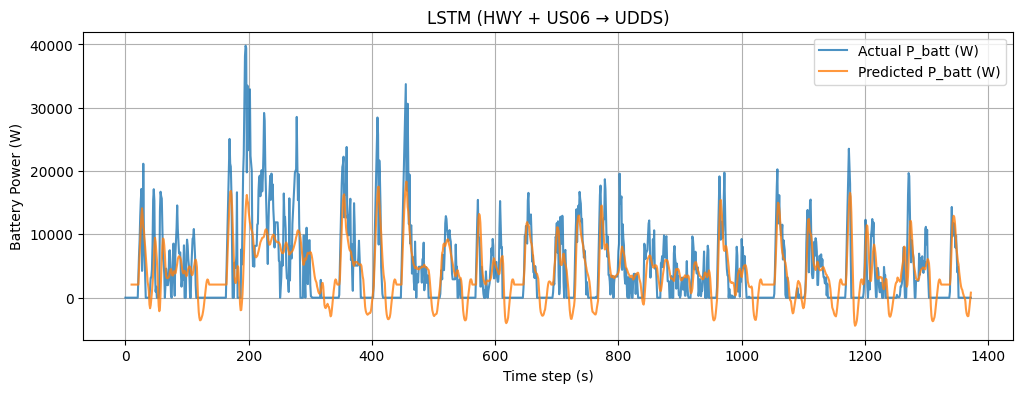

In [97]:
plt.figure(figsize=(12,4))
plt.plot(test_df['P_batt'], label='Actual P_batt (W)', alpha=0.8)
plt.plot(pred_full, label='Predicted P_batt (W)', alpha=0.8)
plt.title("LSTM (HWY + US06 → UDDS)")
plt.xlabel("Time step (s)")
plt.ylabel("Battery Power (W)")
#plt.xlim(0, 800)
plt.legend(); plt.grid()
plt.show()

In [98]:
E_pred_Wh = np.nansum(pred_full) * dt / 3600.0
E_true_Wh = np.sum(test_df['P_batt']) * dt / 3600.0
dist_km = np.sum(test_df['v']) * dt / 1000.0

wh_per_km_pred = E_pred_Wh / dist_km
wh_per_km_true = E_true_Wh / dist_km

print(f"Predicted Wh/km (LSTM): {wh_per_km_pred:.1f}")
print(f"True Wh/km (Physics):   {wh_per_km_true:.1f}")
print(f"Relative error: {(wh_per_km_pred/wh_per_km_true - 1)*100:.2f}%")

Predicted Wh/km (LSTM): 131.5
True Wh/km (Physics):   148.7
Relative error: -11.53%


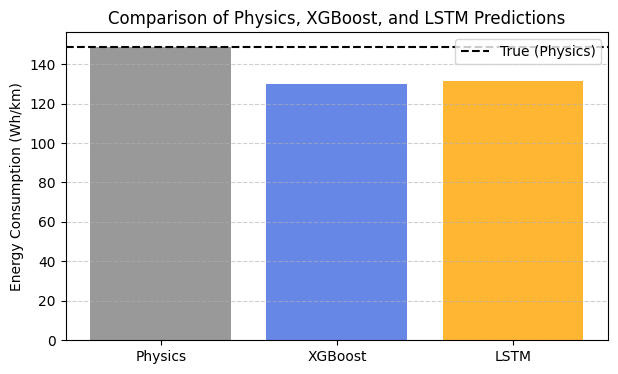

In [99]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Physics', 'XGBoost', 'LSTM']
preds = [148.7, 129.70, 131.5]   # replace with your actual values
true_val = 148.7

plt.figure(figsize=(7,4))
bars = plt.bar(models, preds, color=['gray','royalblue','orange'], alpha=0.8)
plt.axhline(true_val, color='black', linestyle='--', label='True (Physics)')
plt.ylabel('Energy Consumption (Wh/km)')
plt.title('Comparison of Physics, XGBoost, and LSTM Predictions')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()